In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import json
from PIL import Image
import requests
from PIL import Image
from tqdm.notebook import tqdm
os.chdir("/root/TAC/")
DATA_PREFIX = "/root/TAC/data/rgbd_data/pretrain_val"
import torch
import torch.nn.functional as F
import imports
from config.default import get_config
from common.registry import registry


In [2]:
config = get_config("config/v2/v2_tac.yaml")

model_cls = registry.get_model(config.MODEL.name)
model = model_cls.from_config(config)
ckpt = torch.load("/root/TAC/data/checkpoints/tacv2_tac/ckpt.TAC.00.pth")
model.load_state_dict(ckpt["state_dict"])
device = torch.device("cuda")
model.to(device)
model.train()

loader_cls = registry.get_dataloader(config.TRAINER.loaders[0])
loader = loader_cls(
    config,
    mode="eval"
)

_, batch = next(enumerate(loader))
for k,v in model.named_modules():
    if k.endswith("self_attn"):
        v.dropout=0.0

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.4.self_attn.out_proj.bias', 'text_model.encoder.layers.3.self_attn.k_proj.bias', 'text_model.encoder.layers.3.mlp.fc2.weight', 'text_model.encoder.layers.9.self_attn.out_proj.bias', 'text_model.encoder.layers.1.self_attn.q_proj.weight', 'text_model.encoder.layers.4.self_attn.v_proj.weight', 'text_model.encoder.layers.2.self_attn.v_proj.bias', 'text_model.encoder.layers.9.mlp.fc2.bias', 'text_model.encoder.layers.3.layer_norm2.weight', 'text_model.encoder.layers.2.self_attn.v_proj.weight', 'text_model.encoder.layers.3.self_attn.v_proj.weight', 'text_model.encoder.layers.7.self_attn.k_proj.bias', 'text_model.encoder.layers.11.mlp.fc2.bias', 'text_model.encoder.layers.4.layer_norm1.weight', 'text_model.encoder.layers.5.self_attn.v_proj.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.final_layer_norm.bias', 'text_model.encoder.la

In [110]:
ratio = 0.5
start = 25
samples = 12
estimate_num = 100
batch = {
    k: (v.to(device) if isinstance(v, torch.Tensor) else v)
    for k, v in batch.items()
}

for k,v in model.named_modules():
    if k.endswith("self_attn"):
        v.dropout=0.1

logits_show = []
depth_files = []
rgb_files = []
with torch.no_grad():
    for _ in range(estimate_num):
        res = model(batch)
        logits_show.append(F.softmax(res["logits"],dim=0)[start:start+samples, start:start+samples].cpu().numpy())

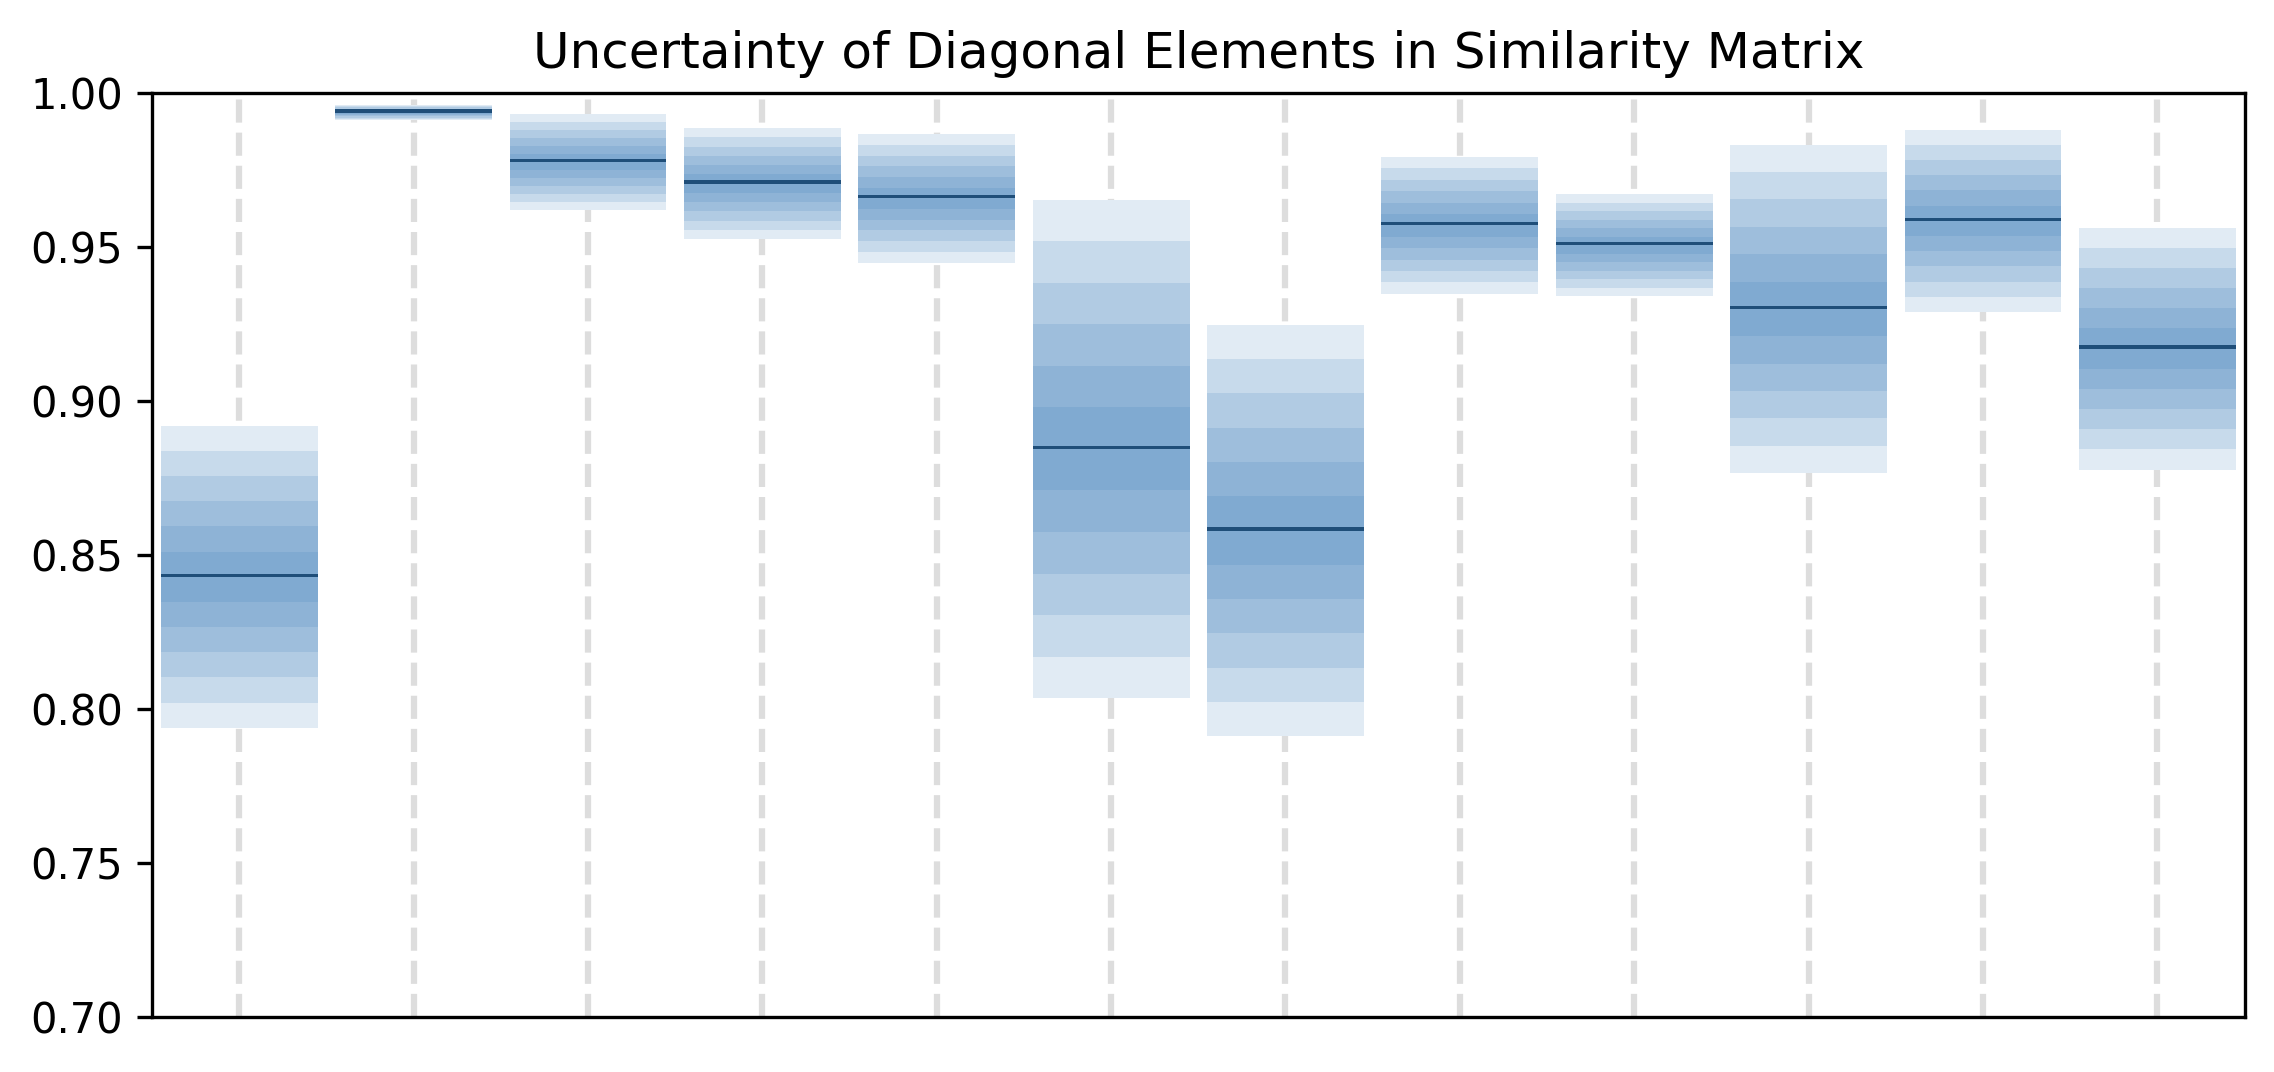

In [113]:
probs = np.array([v.diagonal() for v in logits_show])
stds = np.std(probs, axis=0)
means = np.mean(probs, axis=0)
lower = [means-0.5*i*stds for i in range(1,7)]
upper = [means+0.5*i*stds for i in range(1,7)]

plt.figure(figsize=(9,4),dpi=300)
for i in list(range(len(means))):
    plt.axvline(x=i, color='#dddddd', linestyle="--")

plt.bar(x=list(range(len(lower[-1]))), height=(upper[-1]-lower[-1]),bottom=lower[-1],color="white", width=0.9, zorder=200)
for i in reversed(range(len(lower))):
    plt.bar(x=list(range(len(lower[i]))), height=(upper[i]-lower[i]),bottom=lower[i],color="#2e75b624", width=0.9, zorder=200)
plt.bar(x=list(range(len(lower[i]))), height=0.001,bottom=means,color="#1f4e79", width=0.9, zorder=200)
plt.ylim([0.7,1.0])
plt.xlim([-0.5,11.5])
plt.xticks([])
plt.title("Uncertainty of Diagonal Elements in Similarity Matrix")
plt.savefig("uncertainty.png",bbox_inches="tight",dpi=300)
plt.show()

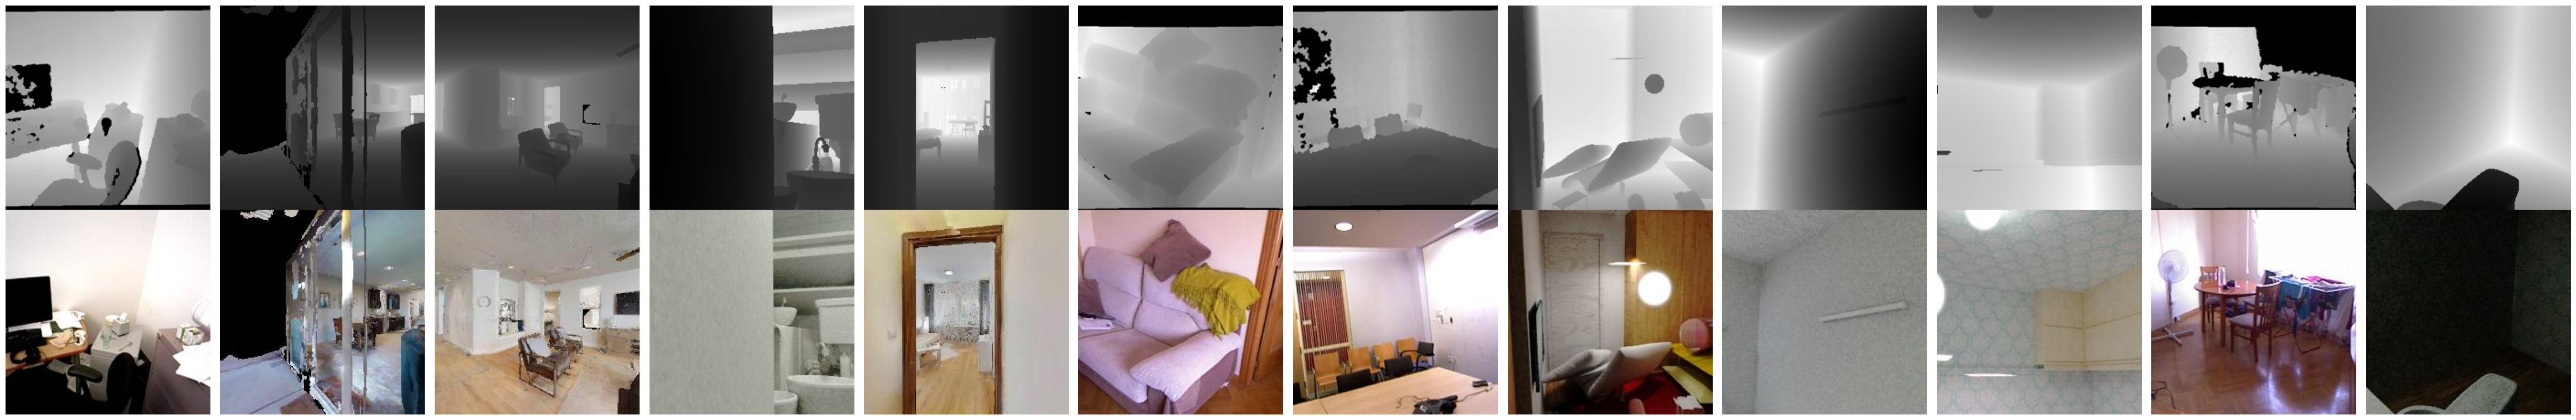

In [86]:

rgb_files = batch["file_path"][start:start+samples]
depth_files= [v.replace("/rgb/","/depth/").replace(".jpg",".png") for v in batch["file_path"]][start:start+samples]
fig, axs = plt.subplots(nrows=2,ncols=12,figsize=(12*5.0,9.6))
for i in range(12):
    img = Image.open(depth_files[i])
    img = np.array(img).astype(float)
    axs[0][i].axis(False)
    axs[0][i].imshow(img,cmap="gray")
for i in range(12):
    img = Image.open(rgb_files[i])
    axs[1][i].axis(False)
    axs[1][i].imshow(img)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("uncertainty_images.png",bbox_inches="tight")
plt.show()

In [114]:
stds

array([0.01633913, 0.00082164, 0.00515375, 0.00599577, 0.00692932,
       0.0269831 , 0.02227398, 0.00740514, 0.00551819, 0.01777176,
       0.00985894, 0.01309138], dtype=float32)